In [149]:
import cv2 as cv
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

from gen_images import make_transform
import os
import re
from typing import List, Optional, Tuple, Union

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
from scipy import fftpack
from werkzeug.utils import secure_filename
import sklearn as sk
import legacy
from sklearn.cluster import KMeans


import io
import base64

from sklearn.decomposition import PCA

#network_pkl = "models/stylegan3-r-ffhq-1024x1024.pkl"
network_pkl = "models/stylegan3-r-afhqv2-512x512.pkl"
seeds = [1]
truncation_psi = 0.7
class_idx = None
noise_mode = "const"
outdir = "server_outputs"
translate = (0.0, 0.0)
rotate = 0.0
G = None

def generate_image(latent_vector):
    global G
    device = torch.device('cuda')
    if G is None:
        with dnnlib.util.open_url(network_pkl) as f:
            G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
    os.makedirs(outdir, exist_ok=True)

    label = torch.zeros([1, G.c_dim], device=device)
    if G.c_dim != 0:
        if class_idx is None:
            raise click.ClickException('Must specify class label with --class when using a conditional network')
        label[:, class_idx] = 1
    else:
        if class_idx is not None:
            print ('warn: --class=lbl ignored when running on an unconditional network')

    for seed_idx, seed in enumerate(seeds):
        z = torch.from_numpy(latent_vector).to(device)
        if hasattr(G.synthesis, 'input'):
            m = make_transform(translate, rotate)
            m = np.linalg.inv(m)
            G.synthesis.input.transform.copy_(torch.from_numpy(m))
        img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        np_img = img[0].cpu().numpy()
        if len(np_img.shape) < 3 or np_img.shape[-1] < 3:
            np_img = np.stack([np_img[:, :, 0]]*3, axis=-1)
        return np_img
    


def find_palette(image, palette_size):
    #Save time, resize to 100x100
    image = cv.resize(image, (100, 100))

    pixels = np.float32(image.reshape(-1, 3))

    kmeans = KMeans(n_clusters=palette_size, random_state=42)
    kmeans.fit(pixels)

    palette = np.uint8(kmeans.cluster_centers_)
    return palette

def find_color_grid(img, grid_size=(3,3)):
    sx = img.shape[1] // grid_size[0]
    sy = img.shape[0] // grid_size[1]
    color_array = np.zeros((*grid_size, 3))
    for ix in range(grid_size[0]):
        for iy in range(grid_size[1]):
            start_x = ix*sx
            start_y = iy*sy
            end_x = start_x + sx
            end_y = start_y + sy
            field = img[start_y:end_y, start_x:end_x]
            primary_color = find_palette(field, 1)[0]
            color_array[iy, ix] = primary_color
    np_arr = np.array(color_array)
    return np_arr

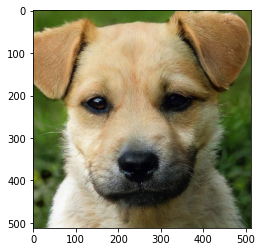

In [191]:
test_img = generate_image(np.random.normal(size=(1,512), loc=0, scale=1))
plt.imshow(test_img)
plt.show()

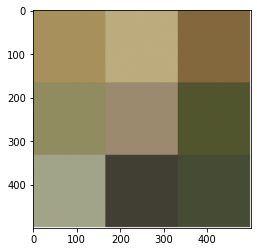

In [192]:
display = np.ones((500, 500, 3))
color_grid = find_color_grid(test_img, grid_size=(3,3))
sx = display.shape[1] // color_grid.shape[1]
sy = display.shape[0] // color_grid.shape[0]
for ix in range(color_grid.shape[1]):
    for iy in range(color_grid.shape[0]):
        display[iy*(sy):(iy+1)*sy, ix*sx:(ix+1)*sx] = color_grid[iy, ix]/255.0
plt.imshow(display)

In [193]:
random_faces = [
    generate_image(np.random.normal(size=(1,512), loc=0, scale=1)) for _ in range(3000)
]

In [194]:
pixel_kernel_size = 3

In [195]:
col_grids = [find_color_grid(face, grid_size=(pixel_kernel_size,pixel_kernel_size)) for face in random_faces]

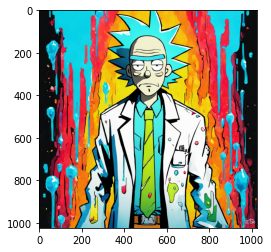

In [196]:
# Load the target_image:
target_image = cv.imread("ricks/2023-09-10_00-41-57_4891.png")[:, :, ::-1]
plt.imshow(target_image)

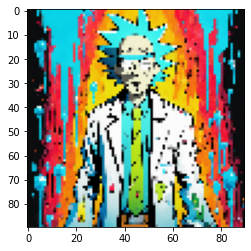

In [197]:
scaled = cv.resize(target_image, (pixel_kernel_size*30, pixel_kernel_size*30))
plt.imshow(scaled)

In [198]:
windows = []
coords = []
positioned_faces = []
for ix in range(0, scaled.shape[1], pixel_kernel_size):
    for iy in range(0, scaled.shape[0], pixel_kernel_size):
        windows.append(scaled[iy:iy+pixel_kernel_size, ix:ix+pixel_kernel_size])
        coords.append((ix, iy))

In [199]:
for window in windows:
    best_dist = None
    best_face = None
    for face, grid in zip(random_faces, col_grids):
        dist = np.sum(((grid/255.0) - (window/255.0))**2)
        if best_dist is None or dist < best_dist:
            best_dist = dist
            best_face = face
    positioned_faces.append(best_face)

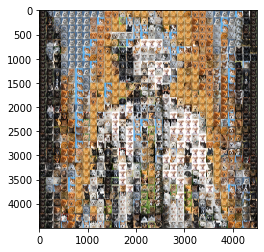

In [200]:
result_size = 4500

size_x = result_size // (scaled.shape[1])
size_y = result_size // (scaled.shape[0])

result = np.ones((result_size, result_size, 3))
for face, coordinate in zip(positioned_faces, coords):
    try:
        x, y = coordinate
        resized_face = cv.resize(face, (size_y, size_x))
        result[y*size_y:(y+pixel_kernel_size)*size_y, x*size_x:(x+pixel_kernel_size)*size_x] = cv.resize(resized_face, (pixel_kernel_size*size_x, pixel_kernel_size*size_y))
    except:
        pass
plt.imshow(result/255.0)


In [201]:
cv.imwrite("knn-collage.png", result[:, :, ::-1])

True